In [1]:
%matplotlib inline
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from sklearn import datasets
plt.style.use("ggplot")
pd.set_option('display.max_rows', 500)
print("done")

done


# Plan

### Utforske
1. Splitt sett og fjern ID. Bruker X_test som devsett siden submission er testsett.
2. Se på korrelasjoner
3. Se på tallverdier og balanse

### Manipuler
1. Imputere
2. Jevne ut treningseksempler med oversampling (PRØV LITT FORSKJELLIG)
3. Lag polynomial features
4. Skaler minmax (0->1)
5. Best feature selection. Prøv ulike k verdier mot RF.

### Modell
1. Random forrest
2. GBC
3. Logistic Regression
3. NN (for tidkrevende..)
    - Diverse arkitektur
Kryssvalidering

### Ensemble
1. Random forrest med div random_state + andre modeller
Kryssvalider

In [2]:
# Laste datasett
df = pd.read_csv('train.csv')
final_test = pd.read_csv('test.csv')
print("done")

done


In [3]:
df.head()

,id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,target
0,161363,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,8.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,6
1,78028,16.0,0.0,1.0,1.0,6.0,2.0,2.0,2.0,14.0,...,0.0,41.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,7
2,35324,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,5
3,67966,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1
4,110279,3.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,NaN,...,0.0,0.0,1.0,5.0,4.0,0.0,0.0,0.0,1.0,5


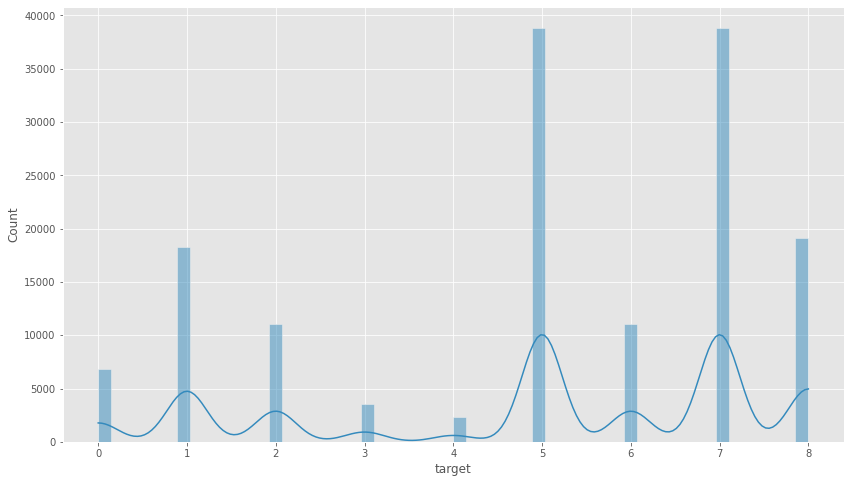

In [4]:
plt.figure(figsize=(14,8))
sns.histplot(df.target, kde=True)
plt.show()

In [5]:
# Splitt sett og fjern ID
X = df.drop(["id", "target"], axis=1)
y = df.target

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
# Korrelasjon
train_df = pd.concat([X_train, y_train], axis=1)
correlation = abs(train_df.corr()["target"].sort_values(ascending=False))
correlation

target    1.000000
f_18      0.109225
f_12      0.098614
f_37      0.091127
f_16      0.091115
f_14      0.087081
f_31      0.087022
f_56      0.083190
f_53      0.082934
f_43      0.082718
f_44      0.078521
f_8       0.077783
f_65      0.065839
f_50      0.063174
f_2       0.062145
f_30      0.060896
f_1       0.060701
f_52      0.060658
f_45      0.060602
f_48      0.060213
f_3       0.059389
f_40      0.058565
f_7       0.058184
f_62      0.056302
f_72      0.056286
f_21      0.055670
f_54      0.055190
f_9       0.054638
f_4       0.053981
f_35      0.053606
f_58      0.053503
f_55      0.052959
f_13      0.051407
f_67      0.050199
f_19      0.050083
f_23      0.049936
f_70      0.049498
f_73      0.049412
f_64      0.048424
f_51      0.048145
f_25      0.047777
f_66      0.047245
f_60      0.047217
f_28      0.046377
f_46      0.044630
f_34      0.044065
f_29      0.043046
f_0       0.041229
f_38      0.041060
f_42      0.040706
f_63      0.040113
f_41      0.039773
f_32      0.

# Korrelasjonsverdier ved utskifting av NaN (sum av korrelasjon)
##### No action: 4.7253954611416855
##### Interpolate linear: 4.691405084847958
##### Impute mean: 4.704097869632694 - Bruker denne
##### Impute median: 4.7033247989275875
##### Impute most_frequent: 4.7029082339562125
##### Impute constant: 4.7029082339562125

In [8]:
from sklearn.impute import SimpleImputer

strat = ["mean", "median", "most_frequent", "constant"]

imp_result = []
for s in strat:
    imp = SimpleImputer(strategy=s)
    train_df_imp = imp.fit_transform(train_df)
    train_df_imp = pd.DataFrame(data=train_df_imp, columns=train_df.columns)
    correlation_imp = abs(train_df_imp.corr()["target"].sort_values(ascending=False))
    imp_result.append(sum(correlation_imp))

imp_result

In [9]:
imp = SimpleImputer(strategy="mean")
X_train_imp = imp.fit_transform(X_train)
X_train_imp = pd.DataFrame(data=X_train_imp, columns=X_train.columns)

X_test_imp = imp.transform(X_test)
X_test_imp = pd.DataFrame(data=X_test_imp, columns=X_train.columns)


In [10]:
with pd.option_context('display.max_rows', None):
    print(X_train_imp.isna().sum())

f_0     0
f_1     0
f_2     0
f_3     0
f_4     0
f_5     0
f_6     0
f_7     0
f_8     0
f_9     0
f_10    0
f_11    0
f_12    0
f_13    0
f_14    0
f_15    0
f_16    0
f_17    0
f_18    0
f_19    0
f_20    0
f_21    0
f_22    0
f_23    0
f_24    0
f_25    0
f_26    0
f_27    0
f_28    0
f_29    0
f_30    0
f_31    0
f_32    0
f_33    0
f_34    0
f_35    0
f_36    0
f_37    0
f_38    0
f_39    0
f_40    0
f_41    0
f_42    0
f_43    0
f_44    0
f_45    0
f_46    0
f_47    0
f_48    0
f_49    0
f_50    0
f_51    0
f_52    0
f_53    0
f_54    0
f_55    0
f_56    0
f_57    0
f_58    0
f_59    0
f_60    0
f_61    0
f_62    0
f_63    0
f_64    0
f_65    0
f_66    0
f_67    0
f_68    0
f_69    0
f_70    0
f_71    0
f_72    0
f_73    0
f_74    0
dtype: int64


In [11]:
# Random over and undersampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

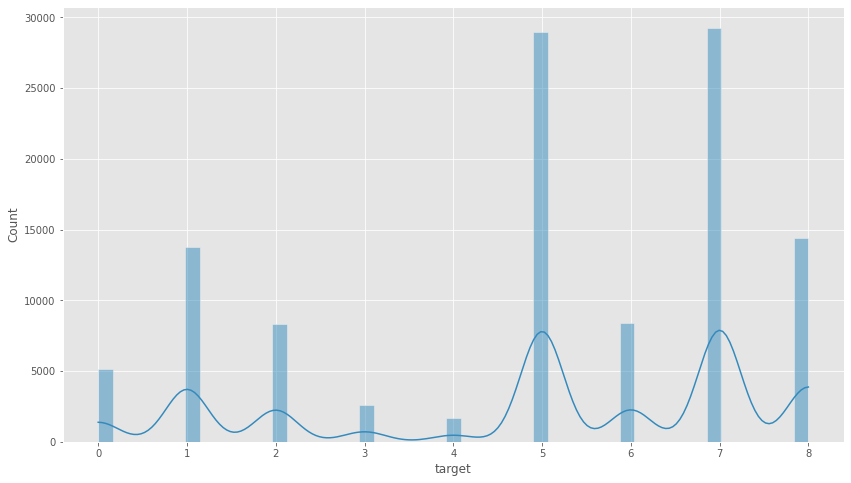

In [12]:
plt.figure(figsize=(14,8))
sns.histplot(y_train, kde=True)
plt.show()

In [13]:
with pd.option_context('display.max_rows', None):
    print(y_train.value_counts())

7    29275
5    28955
8    14375
1    13765
6     8369
2     8307
0     5121
3     2621
4     1712
Name: target, dtype: int64


Test av ulike samlingverdier. Verdiene under gjorde det mulig å kjøre uten kræsj.

In [14]:
#When ``dict``, the keys correspond to the targeted classes. Vi øker de små og reduserer de store.
classes = {0: 5121, 1:13765, 2:8307, 3:5000, 4:5000, 5:28955, 6:8369, 7:29275, 8:14375}
oversample = RandomOverSampler(sampling_strategy=classes)
undersample = RandomUnderSampler(sampling_strategy={1:10000, 5: 20000, 7: 20000, 8:10000})

In [15]:
#oversample
X_train_imp_over, y_train_over = oversample.fit_resample(X_train_imp, y_train)

In [16]:
#undersample
X_train_imp_over_under, y_train_over_under = undersample.fit_resample(X_train_imp_over, y_train_over)

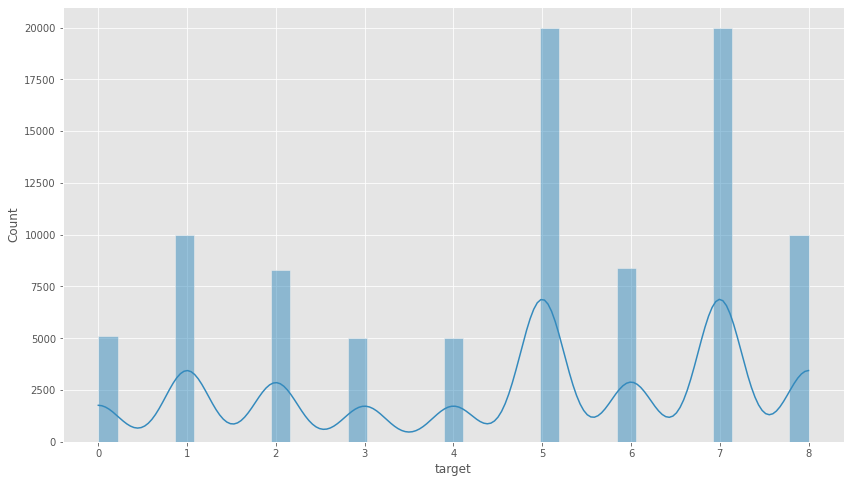

In [17]:
plt.figure(figsize=(14,8))
sns.histplot(y_train_over_under, kde=True)
plt.show()

In [18]:
# Polynomialvariabler
from sklearn.preprocessing import PolynomialFeatures

In [19]:
from math import comb

In [20]:
# Forventet antall features
75 + 75 + comb(75,2)

2925

In [21]:
polys = PolynomialFeatures(degree=2, include_bias=False)

# original
polyfeatures_orig = polys.fit_transform(X_train_imp)
X_train_imp_poly_orig = pd.DataFrame(data=polyfeatures_orig)

In [22]:
# over/under sampling
polyfeatures_sampled = polys.transform(X_train_imp_over_under)
X_train_imp_over_under_poly = pd.DataFrame(data=polyfeatures_sampled)

In [23]:
#test sett
polyfeatures_test = polys.transform(X_test_imp)
X_test_imp_poly = pd.DataFrame(data=polyfeatures_test)

In [24]:
X_train_imp_over_under_poly

,0,1,2,3,4,5,6,7,8,9,...,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3.000000,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,0.000000,0.0,8.0,1.0,1.000000,0.000000,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
2,0.0,0.0,2.213838,3.0,0.0,0.0,0.000000,0.000000,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,1.009283,0.674143,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91792,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91793,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,3.000000,11.0,0.0,...,4.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
91794,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91795,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Skaler
from sklearn.preprocessing import MinMaxScaler

In [26]:
scaler = MinMaxScaler()

# original
scaled_data_orig = scaler.fit_transform(X_train_imp_poly_orig)
X_train_imp_orig_poly_std = pd.DataFrame(data=scaled_data_orig)

In [27]:
# over/under sampled
scaled_data = scaler.transform(X_train_imp_over_under_poly)
X_train_imp_over_under_poly_std = pd.DataFrame(data=scaled_data)

In [28]:
# test data
X_test_scaled_data = scaler.transform(X_test_imp_poly)
X_test_imp_poly_std = pd.DataFrame(data=X_test_scaled_data)

In [29]:
# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [30]:
#methods prøvd = [chi2, f_classif, mutual_info_classif]. chi2 var mulig å gjennomføre.

k = 100

selector_class = SelectKBest(chi2, k=k)
selector_class.fit(X_train_imp_over_under_poly_std, y_train_over_under)
# Get columns for new dataframe
cols = selector_class.get_support(indices=True)

# original
X_train_imp_orig_poly_std_best = X_train_imp_orig_poly_std.iloc[:,cols]

# over/under sampled
X_train_imp_over_under_poly_std_best = X_train_imp_over_under_poly_std.iloc[:,cols]

# Test set
X_test_imp_poly_best = X_test_imp_poly_std.iloc[:,cols]

In [31]:
np.count_nonzero(np.isnan(X_test_imp_poly_best))

0

# TESTING

In [32]:
# Over/under sampled
X_train_sampled = X_train_imp_over_under_poly_std_best
y_train_sampled = y_train_over_under

# Original
X_train_orig = X_train_imp_orig_poly_std_best
y_train_orig = y_train

X_test = X_test_imp_poly_best  # Dev sett
y_test = y_test  # Dev sett

In [33]:
from sklearn import metrics # compute accuracy
from sklearn.metrics import accuracy_score

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
#Random Forest Classifier - Limited features
#depth = [5 -> 30]
for i in [10]:
    rf_clf = RandomForestClassifier(random_state=42, max_depth=i)
    rf_clf.fit(X_train_sampled, y_train_sampled)

    rf_clf_y_train_pred = rf_clf.predict(X_train_orig) #predict on original train set
    rf_clf_y_test_pred = rf_clf.predict(X_test) # predict on test set

    print("Depth: ", i)
    print("k: ", k)
    print("Train accuracy: ", metrics.accuracy_score(y_train_orig, rf_clf_y_train_pred))
    print("Test accuracy: ", metrics.accuracy_score(y_test, rf_clf_y_test_pred))

# Chi2
#Depth:  10
#k:  100
#Train accuracy:  0.3956088888888889
#Test accuracy:  0.3589333333333333

Depth:  10
k:  100
Train accuracy:  0.39642666666666665
Test accuracy:  0.35792


#### Neural network. Oppnådd .35 på devsett. Ikke nok ram til ensemble.. Prøve tensorflow i stedet?

# LOGREG

In [36]:
from sklearn.linear_model import LogisticRegression # Logistic regression

In [37]:
?LogisticRegression

In [38]:
#Logistic regression
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train_sampled,y_train_sampled)

lr_y_train_pred = lr.predict(X_train_orig) #predict on train set
lr_y_test_pred = lr.predict(X_test) # predict on test set

print("Train accuracy: ", metrics.accuracy_score(y_train_orig, lr_y_train_pred))
print("Test accuracy: ", metrics.accuracy_score(y_test, lr_y_test_pred))

# Train accuracy:  0.34298666666666666
# Test accuracy:  0.3428

Train accuracy:  0.3436622222222222
Test accuracy:  0.34341333333333335


# GBC

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
gb = GradientBoostingClassifier(random_state=42, warm_start=True)
#gb.set_params(n_estimators=n, warm_start=True)
gb.fit(X_train_sampled,y_train_sampled)

gb_y_train_pred = gb.predict(X_train_orig) #predict on train set
gb_y_test_pred = gb.predict(X_test) # predict on test set

print("Train accuracy: ", metrics.accuracy_score(y_train_orig, gb_y_train_pred))
print("Test accuracy: ", metrics.accuracy_score(y_test, gb_y_test_pred))

#Train accuracy:  0.3735466666666667
#Test accuracy:  0.35714666666666667

Train accuracy:  0.37355555555555553
Test accuracy:  0.3576533333333333


In [41]:
from sklearn.ensemble import VotingClassifier

In [46]:
from sklearn.neural_network import MLPClassifier # Neural Network

In [50]:
n_models = 10
seed=42

models = [(f"rf_clf{i}", RandomForestClassifier(random_state=seed+i, max_depth=10, n_jobs=-1)) for i in range(n_models)]
models.append(("gb", GradientBoostingClassifier(random_state=seed, warm_start=True)))
models.append(("lr", LogisticRegression(random_state=seed, max_iter=5000, n_jobs=-1)))
models.append(("nn", MLPClassifier(solver="lbfgs", alpha=1e-5, hidden_layer_sizes=(30,20,), random_state=seed, max_iter=10000)))
ensemble = VotingClassifier(models)
ensemble.fit(X_train_sampled, y_train_sampled)

ensemble_y_train_pred = ensemble.predict(X_train_orig) #predict on train set
ensemble_y_test_pred = ensemble.predict(X_test) # predict on test set

print("Train accuracy: ", metrics.accuracy_score(y_train_orig, ensemble_y_train_pred))
print("Test accuracy: ", metrics.accuracy_score(y_test, ensemble_y_test_pred))

# with RF x 10, GBC x 1, LRC x 1
# Train accuracy:  0.39413333333333334
# Test accuracy:  0.35877333333333333

# with RF x 10, GBC x 1, LRC x 2
# Train accuracy:  0.39353777777777776
# Test accuracy:  0.35696

# with RF x 10, GBC x 1, LRC x 1, NN x 1
#Train accuracy:  0.39308444444444446
#Test accuracy:  0.3592533333333333

Train accuracy:  0.39288
Test accuracy:  0.35842666666666667


### Cross validation

In [48]:
from sklearn.model_selection import cross_val_score

In [49]:
scores_ensemble = cross_val_score(ensemble, X_train_orig, y_train_orig, cv=2)
scores_ensemble

C:\Users\torstein\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


array([0.35898667, 0.35987556])

# KNN. Ikke nok minne..

# Send resultat

In [ ]:
final_test_cols = final_test.drop(["id"], axis=1).columns

final_test_imp = imp.transform(final_test.drop(["id"], axis=1))
final_test_imp = pd.DataFrame(data=final_test_imp, columns=final_test_cols)

polyfeatures_final_test = polys.transform(final_test_imp)
final_test_imp_poly = pd.DataFrame(data=polyfeatures_final_test)

In [ ]:
final_test_scaled_data = scaler.transform(final_test_imp_poly)
final_test_imp_poly_std = pd.DataFrame(data=final_test_scaled_data)

final_test_imp_poly_std_best = final_test_imp_poly_std.iloc[:,cols]

target = ensemble.predict(final_test_imp_poly_std_best)
submission = pd.DataFrame({'id': final_test['id'], 'target': target})
submission.head()

In [ ]:
submission.to_csv('final_ensemble_submission.csv', index=False)